In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
from Data_Loader import *
from Generator import *
from Discriminator import *

In [3]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

n_epochs = 10
dim_A = 3
dim_B = 3
display_step = 500
batch_size = 1
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import os
import shutil

def remove_files_in_directory(directory_path):
    if os.path.exists(directory_path):
        for filename in os.listdir(directory_path):
            file_path = os.path.join(directory_path, filename)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}: {e}")
    else:
        print(f"The directory '{directory_path}' does not exist.")

In [6]:
class CycleGan:
  def __init__(self, dim_A, dim_B,emotion,load_model=False):
    self.gen_AB = Generator(dim_A, dim_B).to(device)
    self.gen_BA = Generator(dim_B, dim_A).to(device)
    self.gen_opt = torch.optim.Adam(list(self.gen_AB.parameters()) + list(self.gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
    self.disc_A = Discriminator(dim_A).to(device)
    self.disc_A_opt = torch.optim.Adam(self.disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
    self.disc_B = Discriminator(dim_B).to(device)
    self.disc_B_opt = torch.optim.Adam(self.disc_B.parameters(), lr=lr, betas=(0.5, 0.999))
    self.emotion = emotion
    if load_model:
      self.load_model('Gan_Results/Models')

  def weights_init(self, m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

  def load_model(self, path):
    path = f'{path}/{self.emotion}'
    model = os.listdir(path)[0]
    pre_dict = torch.load(f'{path}/{model}')

    self.gen_AB.load_state_dict(pre_dict['gen_AB'])
    self.gen_BA.load_state_dict(pre_dict['gen_BA'])
    self.gen_opt.load_state_dict(pre_dict['gen_opt'])
    self.disc_A.load_state_dict(pre_dict['disc_A'])
    self.disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
    self.disc_B.load_state_dict(pre_dict['disc_B'])
    self.disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])

  def weight_initialization(self):
    self.gen_AB = self.gen_AB.apply(self.weights_init)
    self.gen_BA = self.gen_BA.apply(self.weights_init)
    self.disc_A = self.disc_A.apply(self.weights_init)
    self.disc_B = self.disc_B.apply(self.weights_init)

  def save_model(self,path,cur_step):
    em = self.emotion
    remove_files_in_directory(f'{path}/{em}/')
    torch.save({
                        'gen_AB': self.gen_AB.state_dict(),
                        'gen_BA': self.gen_BA.state_dict(),
                        'gen_opt': self.gen_opt.state_dict(),
                        'disc_A': self.disc_A.state_dict(),
                        'disc_A_opt': self.disc_A_opt.state_dict(),
                        'disc_B': self.disc_B.state_dict(),
                        'disc_B_opt': self.disc_B_opt.state_dict()
      }, f"{path}/{em}/Step_{cur_step}.pth")

  def set_dataset(self,dataset):
    self.target_dataset = FilteredDataset(dataset,self.emotion)

In [7]:
def get_identity_loss(real_X, gen_YX, identity_criterion):

    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(real_X, identity_X)
    return identity_loss, identity_X

In [8]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):

    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(real_X, cycle_X)

    return cycle_loss, cycle_X

In [9]:
def Loss_plot(gen, disc ,class_target):

  gen.pop(0)
  x = [i * display_step for i in  range(len(gen))]
  plt.subplot(1, 2, 1)
  plt.plot(x, gen, label='Generator Loss', color='blue')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.title('Generator Loss')
  plt.legend()

  disc.pop(0)
  plt.subplot(1, 2, 2)
  plt.plot(x, disc, label='Discriminator Loss', color='red')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.title('Discriminator Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [10]:
import numpy as np
plt.rcParams["figure.figsize"] = (6, 6)


def train(Emotion_gan,save_model=True):
    Fid_scores = []
    loss_gen = []
    loss_disc = []
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    Emotion_gan.set_dataset(dataset)
    source_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    target_loader = DataLoader(Emotion_gan.target_dataset, batch_size=batch_size, shuffle=True)

    cur_step = 0

    for epoch in range(n_epochs):
        fake_features_list = []
        real_features_list = []

        for real_A, real_B in zip(source_loader,target_loader):
            #print(real_A[0].shape, real_B[0].shape)
            #Real B --> Fake B:Target
            real_A = real_A[0]
            real_B = real_B[0]

            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            Emotion_gan.disc_A_opt.zero_grad()
            with torch.no_grad():
                fake_A = Emotion_gan.gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, Emotion_gan.disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True)
            Emotion_gan.disc_A_opt.step()

            Emotion_gan.disc_B_opt.zero_grad()
            with torch.no_grad():
                fake_B = Emotion_gan.gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, Emotion_gan.disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True)
            Emotion_gan.disc_B_opt.step()

            Emotion_gan.gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, Emotion_gan.gen_AB, Emotion_gan.gen_BA, Emotion_gan.disc_A, Emotion_gan.disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward()
            Emotion_gan.gen_opt.step()

            mean_discriminator_loss += disc_A_loss.item() / display_step
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                loss_gen.append(mean_generator_loss)
                loss_disc.append(mean_discriminator_loss)
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                #show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape[0], target_shape[1]))
                #show_tensor_images(torch.cat([real_B, fake_B]), size=(dim_B, target_shape[0], target_shape[1]),step=cur_step,target=Emotion_gan.emotion)
                show_tensor_images(real_B, fake_B ,step=cur_step,target=Emotion_gan.emotion, num_images=batch_size)
                save_tensor_image(fake_B,cur_step,Emotion_gan.emotion)
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                if save_model:
                    Emotion_gan.save_model('Gan_Results/Models',cur_step)
            cur_step += len(real_A)

    return loss_gen, loss_disc

Epoch 0: Step 0: Generator (U-Net) loss: 0.0014545241594314576, Discriminator loss: 0.000500546932220459


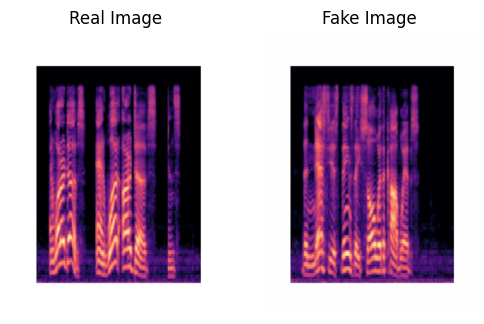

Epoch 1: Step 500: Generator (U-Net) loss: 0.7148173528909688, Discriminator loss: 0.24993396529555328


<Figure size 600x600 with 0 Axes>

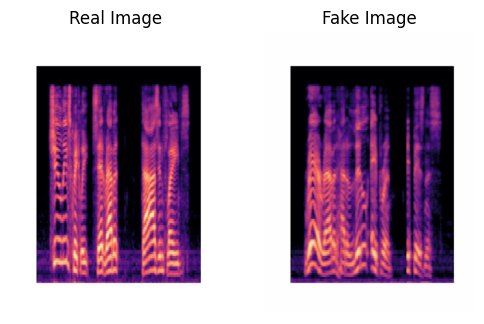

Epoch 2: Step 1000: Generator (U-Net) loss: 0.7135128517150875, Discriminator loss: 0.24992591679096227


<Figure size 600x600 with 0 Axes>

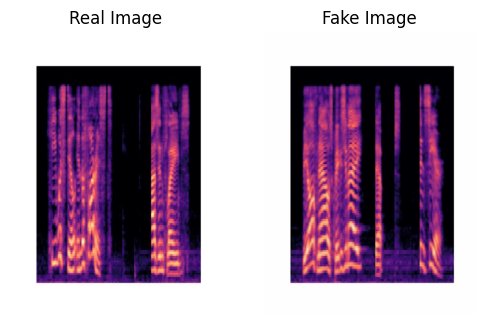

Epoch 3: Step 1500: Generator (U-Net) loss: 0.7075576735734941, Discriminator loss: 0.24990227130055437


<Figure size 600x600 with 0 Axes>

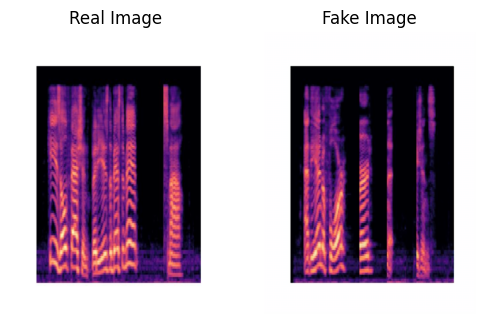

Epoch 4: Step 2000: Generator (U-Net) loss: 0.6976625108718874, Discriminator loss: 0.2498117789924144


<Figure size 600x600 with 0 Axes>

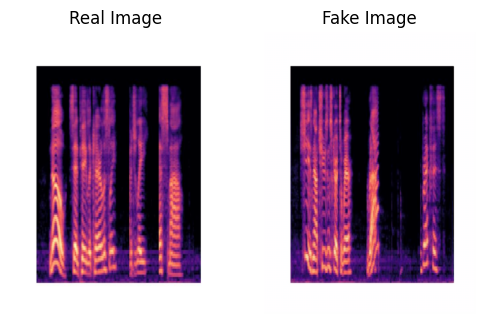

Epoch 5: Step 2500: Generator (U-Net) loss: 0.692838456988334, Discriminator loss: 0.2498548454046251


<Figure size 600x600 with 0 Axes>

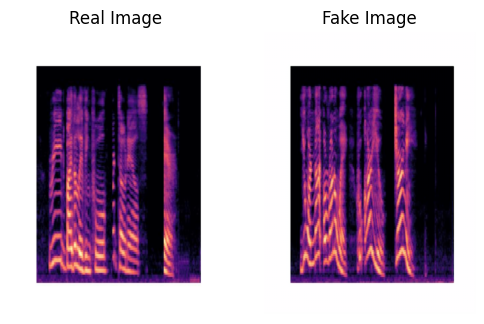

Epoch 6: Step 3000: Generator (U-Net) loss: 0.6872786142826086, Discriminator loss: 0.24981193241476995


<Figure size 600x600 with 0 Axes>

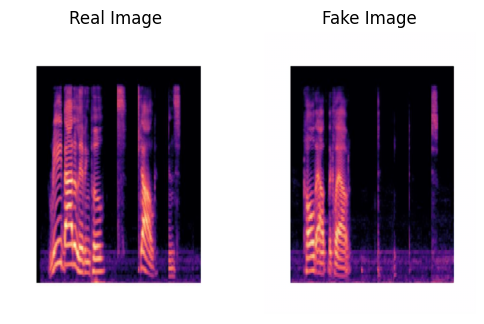

Epoch 7: Step 3500: Generator (U-Net) loss: 0.6841774655580516, Discriminator loss: 0.24980284792184834


<Figure size 600x600 with 0 Axes>

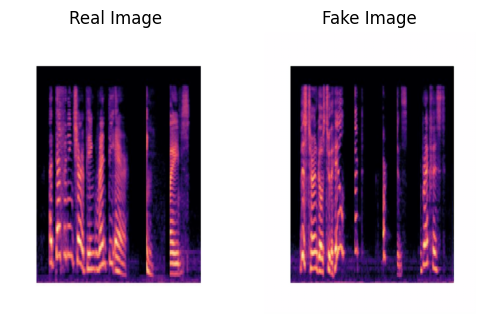

Epoch 8: Step 4000: Generator (U-Net) loss: 0.678394892811775, Discriminator loss: 0.2498001823425295


<Figure size 600x600 with 0 Axes>

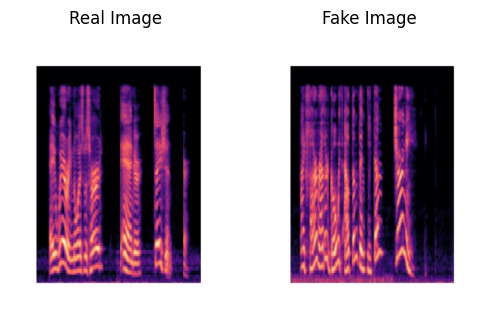

Epoch 9: Step 4500: Generator (U-Net) loss: 0.6745944914817815, Discriminator loss: 0.2498510128855703


<Figure size 600x600 with 0 Axes>

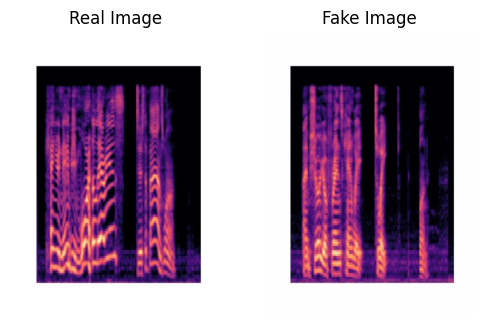

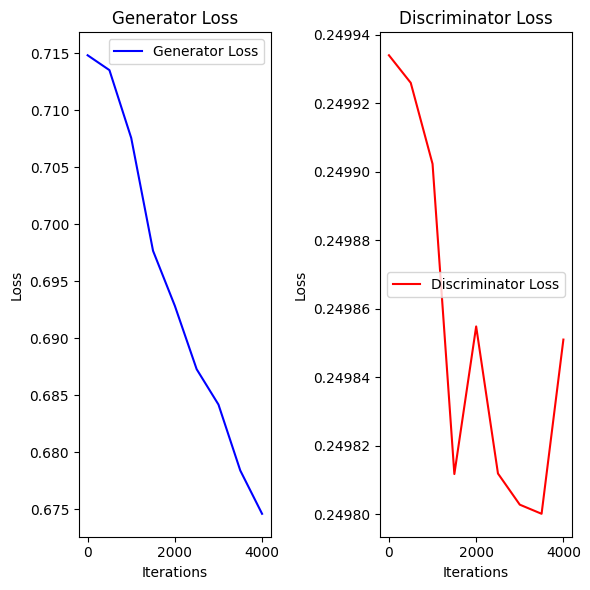

In [11]:
Happy_Gan = CycleGan(3,3,'Happy',load_model=True)
loss_gen, loss_disc = train(Happy_Gan)
Loss_plot(loss_gen, loss_disc,'Happy')

Epoch 0: Step 0: Generator (U-Net) loss: 0.0017252968549728393, Discriminator loss: 0.0004946788847446442


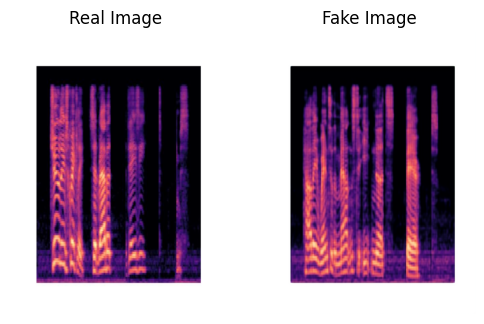

Epoch 4: Step 2000: Generator (U-Net) loss: 0.7644503865242002, Discriminator loss: 0.24879980704188356


<Figure size 600x600 with 0 Axes>

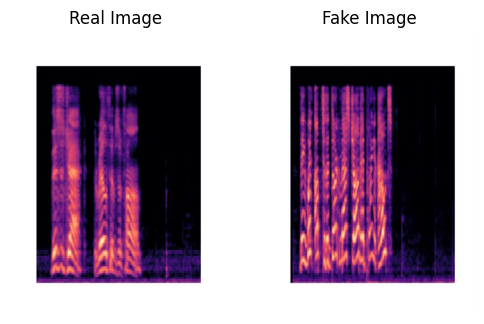

Epoch 5: Step 2500: Generator (U-Net) loss: 0.7519961653947835, Discriminator loss: 0.2488748722374441


<Figure size 600x600 with 0 Axes>

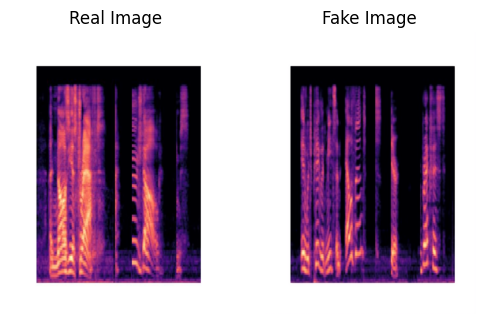

Epoch 6: Step 3000: Generator (U-Net) loss: 0.737798403978348, Discriminator loss: 0.24892881056666377


<Figure size 600x600 with 0 Axes>

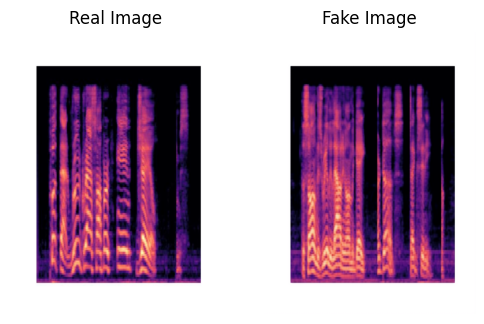

Epoch 7: Step 3500: Generator (U-Net) loss: 0.7312901176214217, Discriminator loss: 0.24906141266226767


<Figure size 600x600 with 0 Axes>

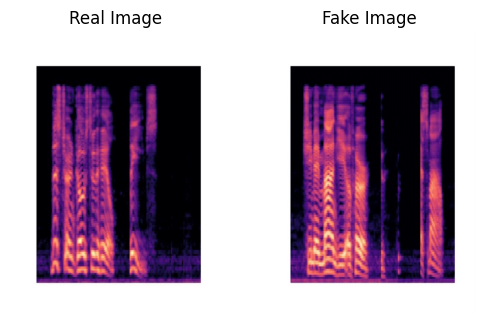

Epoch 8: Step 4000: Generator (U-Net) loss: 0.7252373844385145, Discriminator loss: 0.2494089757502079


<Figure size 600x600 with 0 Axes>

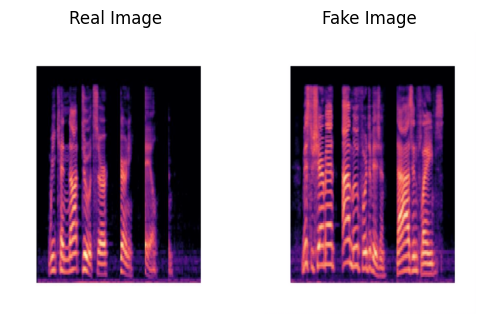

Epoch 9: Step 4500: Generator (U-Net) loss: 0.7157850995063777, Discriminator loss: 0.24936449873447433


<Figure size 600x600 with 0 Axes>

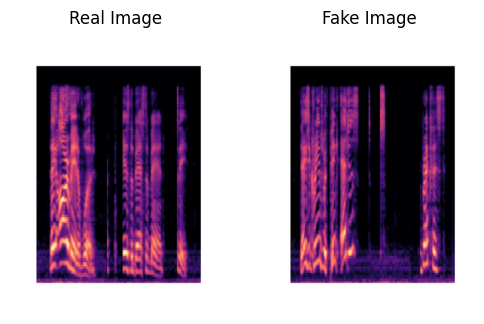

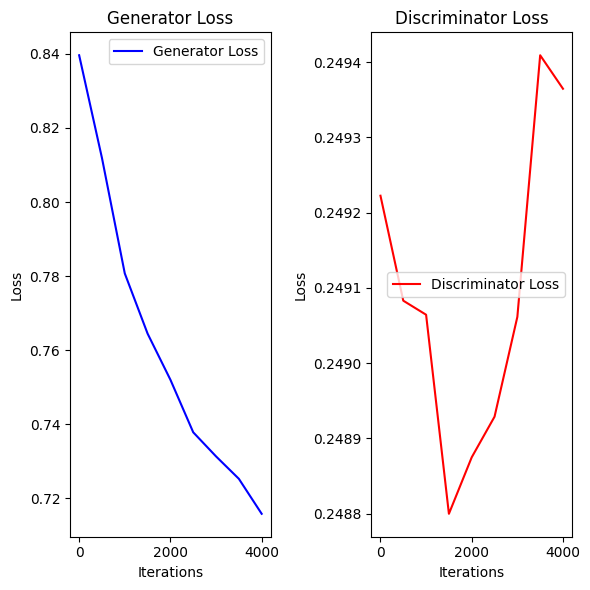

In [12]:
Angry_Gan = CycleGan(3,3,'Angry',load_model=True)
loss_gen, loss_disc = train(Angry_Gan)
Loss_plot(loss_gen, loss_disc,'Angry')

Epoch 0: Step 0: Generator (U-Net) loss: 0.03673147201538086, Discriminator loss: 0.0011832083463668823


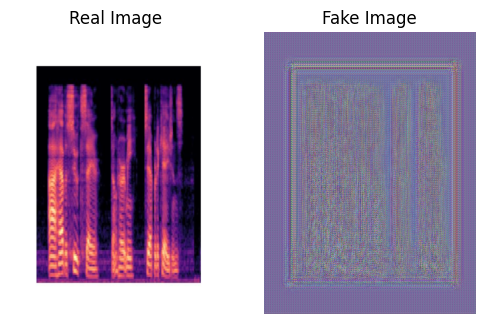

Epoch 0: Step 500: Generator (U-Net) loss: 2.337195914745329, Discriminator loss: 0.23793803972005856


<Figure size 600x600 with 0 Axes>

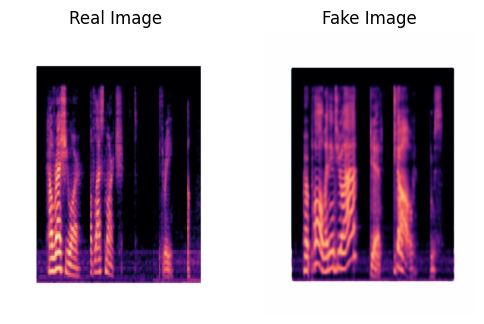

Epoch 1: Step 1000: Generator (U-Net) loss: 1.193398482799529, Discriminator loss: 0.250392784923315


<Figure size 600x600 with 0 Axes>

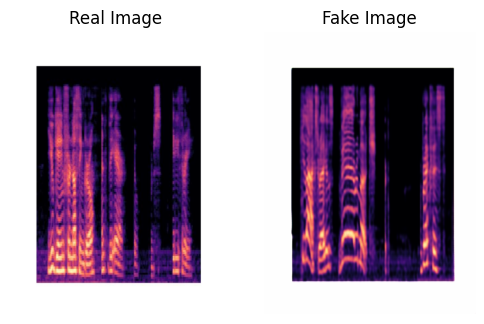

Epoch 2: Step 1500: Generator (U-Net) loss: 1.0336925103664394, Discriminator loss: 0.25083612838387487


<Figure size 600x600 with 0 Axes>

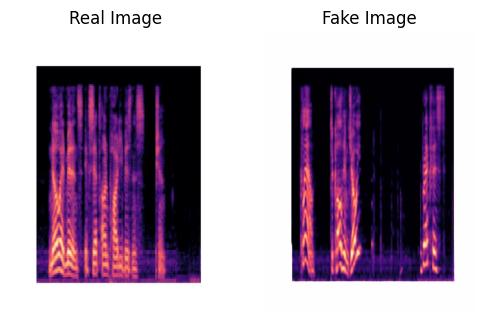

Epoch 3: Step 2000: Generator (U-Net) loss: 0.9636505887508399, Discriminator loss: 0.2507268600463869


<Figure size 600x600 with 0 Axes>

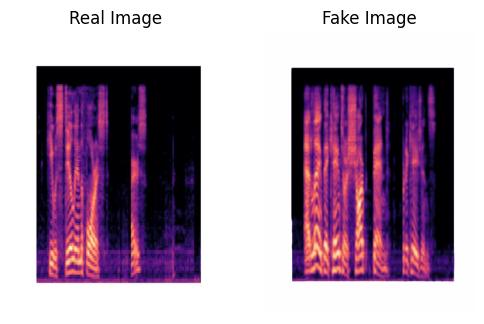

Epoch 4: Step 2500: Generator (U-Net) loss: 0.9366972936391835, Discriminator loss: 0.25049320206046116


<Figure size 600x600 with 0 Axes>

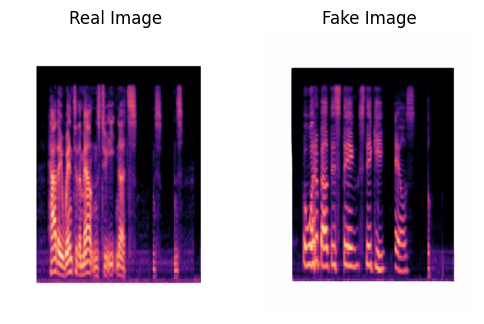

Epoch 5: Step 3000: Generator (U-Net) loss: 0.9098350543975842, Discriminator loss: 0.25015841788053533


<Figure size 600x600 with 0 Axes>

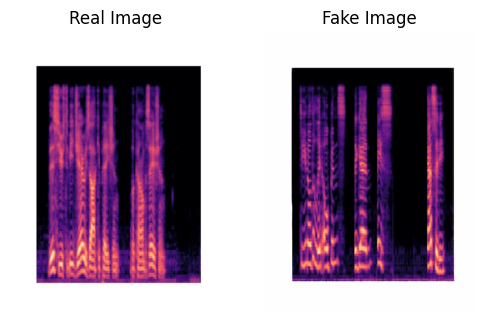

Epoch 6: Step 3500: Generator (U-Net) loss: 0.8935047833919524, Discriminator loss: 0.2496904259324076


<Figure size 600x600 with 0 Axes>

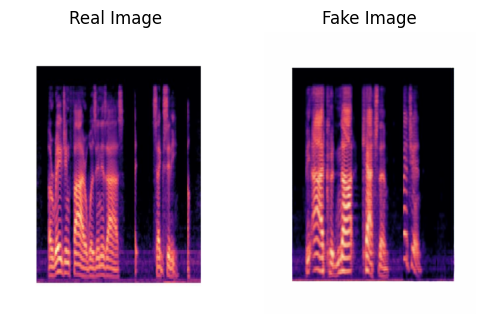

Epoch 7: Step 4000: Generator (U-Net) loss: 0.871906481623649, Discriminator loss: 0.24977751681208615


<Figure size 600x600 with 0 Axes>

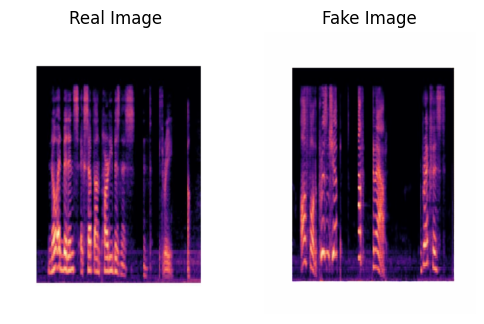

Epoch 8: Step 4500: Generator (U-Net) loss: 0.8513767045736312, Discriminator loss: 0.2487914906144145


<Figure size 600x600 with 0 Axes>

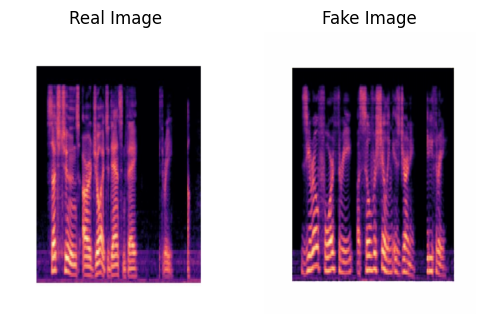

In [ ]:
Neutral_Gan = CycleGan(3,3,'Neutral',load_model=False)
loss_gen, loss_disc = train(Neutral_Gan)
Loss_plot(loss_gen, loss_disc,'Neutral')

Epoch 0: Step 0: Generator (U-Net) loss: 0.001449320912361145, Discriminator loss: 0.0004998550415039062


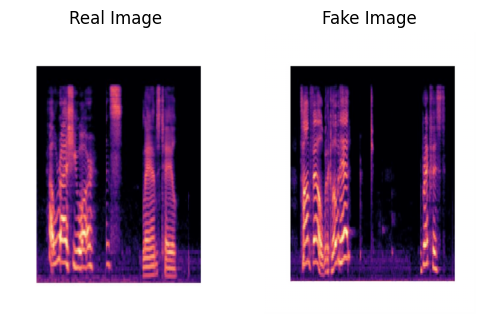

Epoch 1: Step 500: Generator (U-Net) loss: 0.7065732908248895, Discriminator loss: 0.25001163750886923


<Figure size 600x600 with 0 Axes>

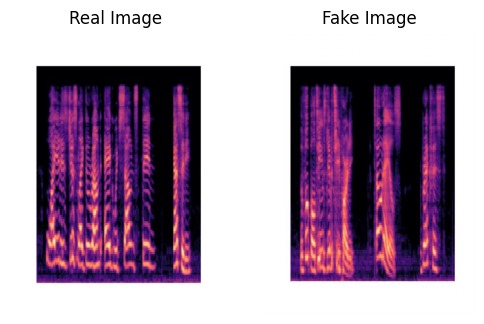

Epoch 2: Step 1000: Generator (U-Net) loss: 0.7017054309844974, Discriminator loss: 0.25005411857366544


<Figure size 600x600 with 0 Axes>

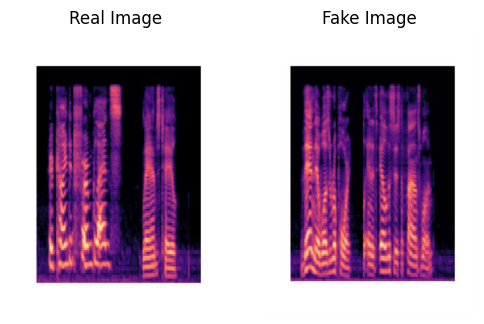

Epoch 3: Step 1500: Generator (U-Net) loss: 0.6962991816997522, Discriminator loss: 0.25005166655778893


<Figure size 600x600 with 0 Axes>

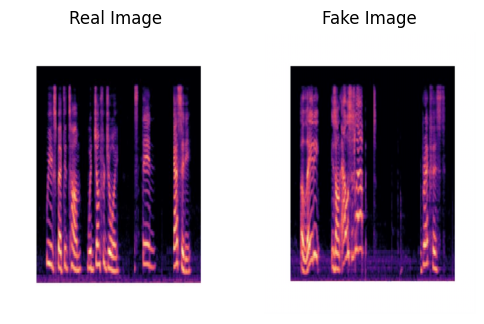

Epoch 4: Step 2000: Generator (U-Net) loss: 0.6890015766620635, Discriminator loss: 0.25006734883785237


<Figure size 600x600 with 0 Axes>

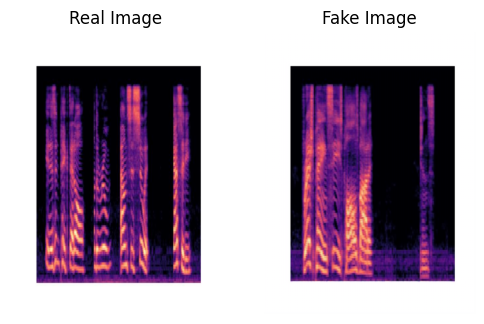

Epoch 5: Step 2500: Generator (U-Net) loss: 0.6846126666069035, Discriminator loss: 0.2500279343724251


<Figure size 600x600 with 0 Axes>

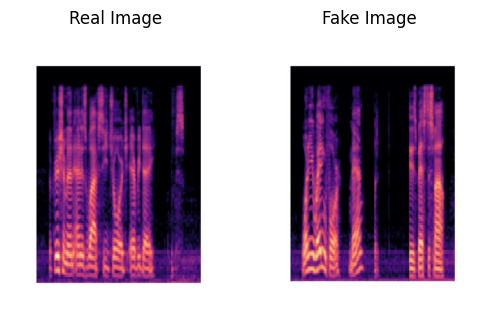

Epoch 6: Step 3000: Generator (U-Net) loss: 0.6797800196409226, Discriminator loss: 0.250106891810894


<Figure size 600x600 with 0 Axes>

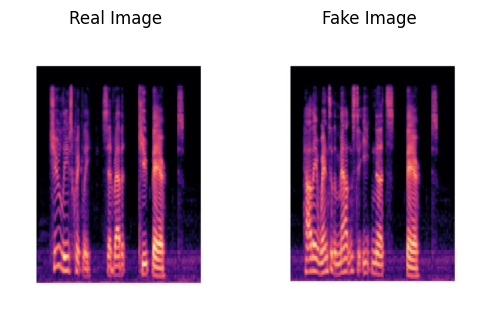

Epoch 7: Step 3500: Generator (U-Net) loss: 0.6729685025215143, Discriminator loss: 0.24997714483737937


<Figure size 600x600 with 0 Axes>

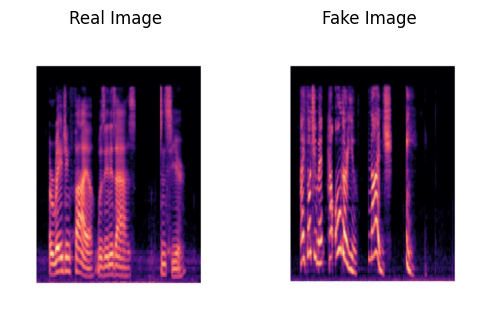

Epoch 8: Step 4000: Generator (U-Net) loss: 0.6708518961668012, Discriminator loss: 0.2499993461072446


<Figure size 600x600 with 0 Axes>

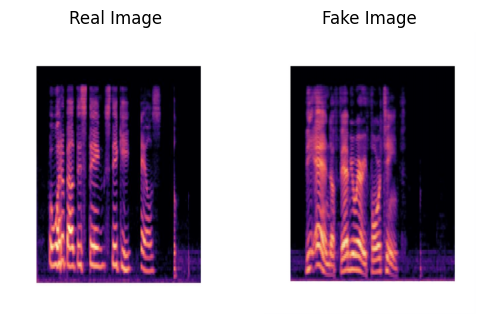

Epoch 9: Step 4500: Generator (U-Net) loss: 0.6675527957677837, Discriminator loss: 0.2500587650239466


<Figure size 600x600 with 0 Axes>

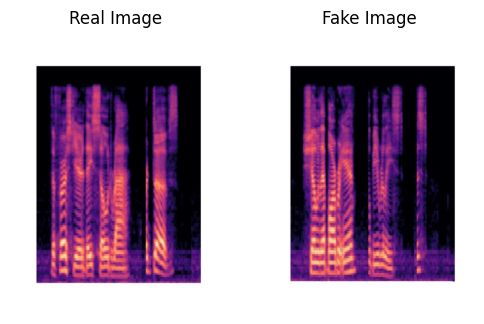

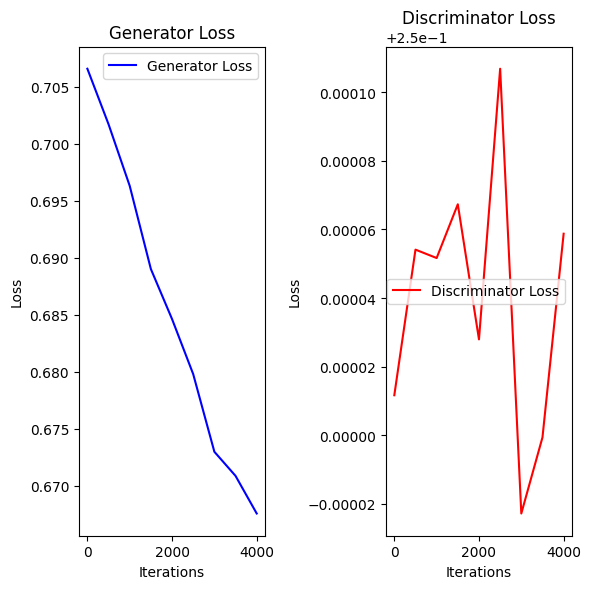

In [12]:
Sad_Gan = CycleGan(3,3,'Sad',load_model=True)
loss_gen, loss_disc = train(Sad_Gan)
Loss_plot(loss_gen, loss_disc,'Sad')

Epoch 0: Step 0: Generator (U-Net) loss: 0.0016521174907684327, Discriminator loss: 0.0004899857640266418


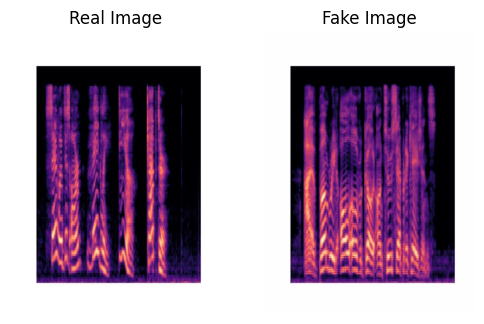

Epoch 1: Step 500: Generator (U-Net) loss: 0.9414256024360667, Discriminator loss: 0.30691055294871333


<Figure size 600x600 with 0 Axes>

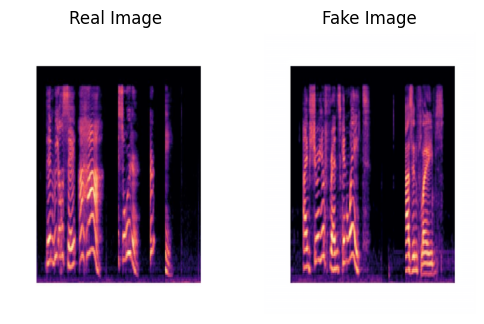

Epoch 2: Step 1000: Generator (U-Net) loss: 0.8188440204858777, Discriminator loss: 0.2615475676357747


<Figure size 600x600 with 0 Axes>

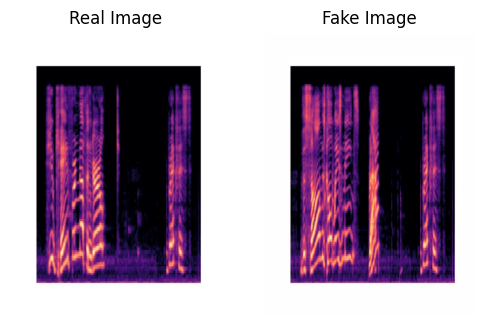

Epoch 3: Step 1500: Generator (U-Net) loss: 0.7981105655431752, Discriminator loss: 0.25152645656466494


<Figure size 600x600 with 0 Axes>

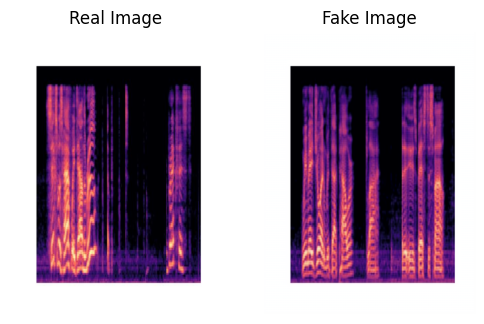

Epoch 4: Step 2000: Generator (U-Net) loss: 0.7883563002347941, Discriminator loss: 0.2512870704233647


<Figure size 600x600 with 0 Axes>

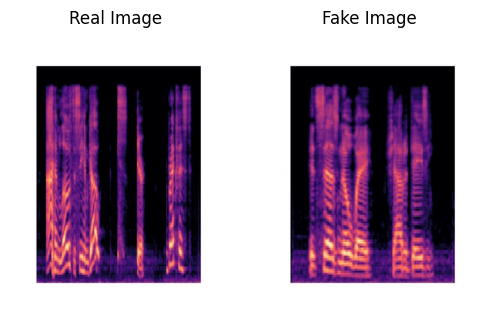

Epoch 5: Step 2500: Generator (U-Net) loss: 0.7776333693265907, Discriminator loss: 0.2503046701550482


<Figure size 600x600 with 0 Axes>

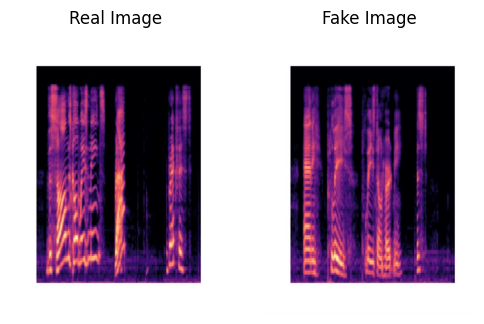

Epoch 6: Step 3000: Generator (U-Net) loss: 0.7694797703027717, Discriminator loss: 0.2500405508875849


<Figure size 600x600 with 0 Axes>

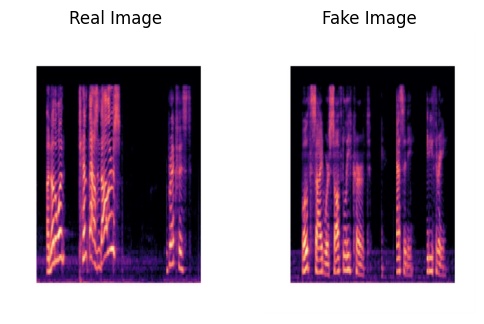

Epoch 7: Step 3500: Generator (U-Net) loss: 0.7584054059982303, Discriminator loss: 0.2499657546579841


<Figure size 600x600 with 0 Axes>

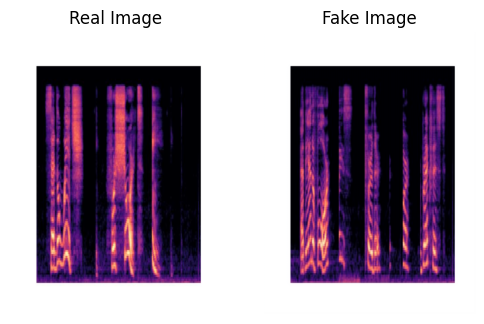

Epoch 8: Step 4000: Generator (U-Net) loss: 0.7537738220691683, Discriminator loss: 0.24964973971247661


<Figure size 600x600 with 0 Axes>

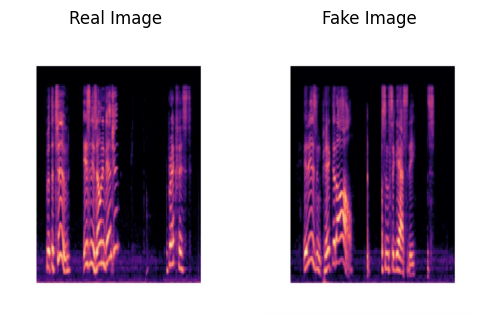

Epoch 9: Step 4500: Generator (U-Net) loss: 0.7464690935611732, Discriminator loss: 0.2494453145861626


<Figure size 600x600 with 0 Axes>

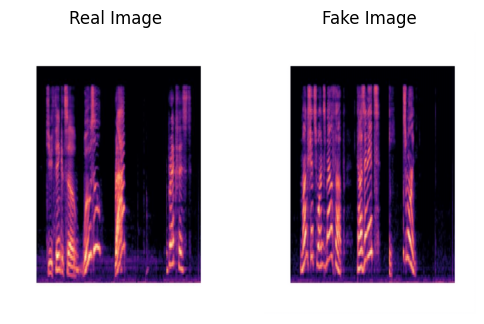

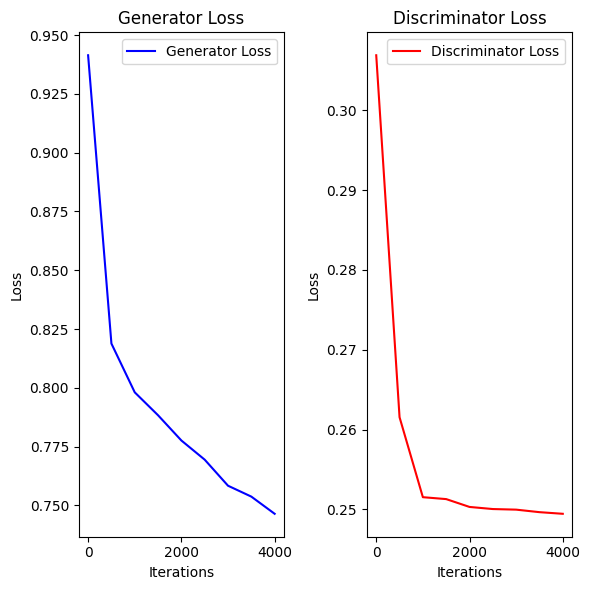

In [13]:
Surprise_Gan = CycleGan(3,3,'Surprise',load_model=True)
loss_gen, loss_disc = train(Surprise_Gan)
Loss_plot(loss_gen, loss_disc,'Surprise')